# **Problem 2: Multilayer perceptron neural networks**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
from torch.utils.data import random_split, DataLoader
import torch.nn.init as init

*Load and display FashionMNIST dataset*

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))])
trainset = torchvision.datasets.FashionMNIST(
    root = './data' , train = True, download = True,
    transform = transform)
testset = torchvision.datasets.FashionMNIST(
    root = './data' , train = False, download = True,
    transform = transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(
    testset, batch_size = 64, shuffle = False)

In [3]:
# Display dataset sizes
print(f'Trainset size: {len(trainset)} samples')
print(f'Testset size: {len(testset)} samples')

Trainset size: 60000 samples
Testset size: 10000 samples


In [4]:
# Splitting data into training and validation sets
val_size = int(0.125 * len(trainset))  
train_size = len(trainset) - val_size 

trainset, valset = random_split(trainset, [train_size, val_size])

# Creating DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

print(f'Trainset size: {len(trainset)} samples')
print(f'Validation set size: {len(valset)} samples')
print(f'Testset size: {len(testset)} samples')

Trainset size: 52500 samples
Validation set size: 7500 samples
Testset size: 10000 samples


In [5]:
print("Classes in FashionMNIST dataset:", trainset.dataset.classes)

Classes in FashionMNIST dataset: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
fashion_mnist_classes = [
    'T-shirt/top',   # Label 0 
    'Trouser',    
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'     # Label 9
] 

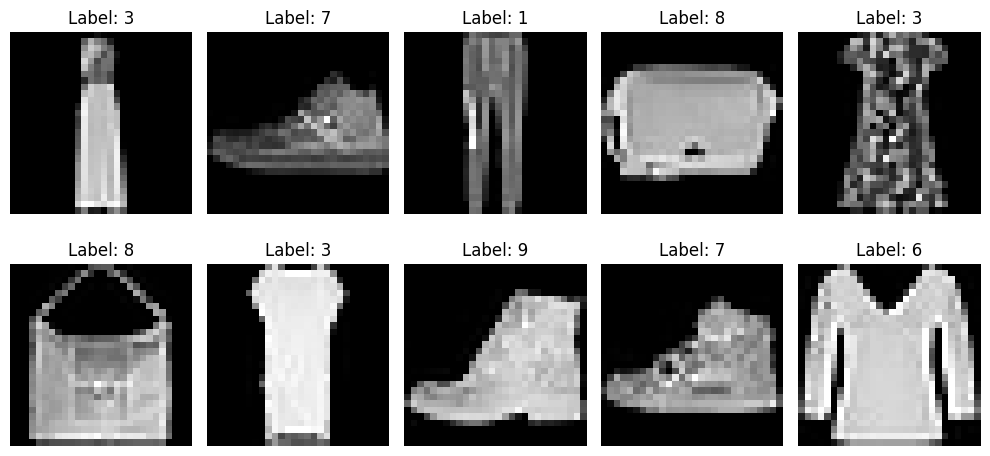

In [7]:
# Define a function to display sample images
def show_FashionMnist_images(dataset, num_images):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.squeeze()  # Remove channel dimension
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 10 images from the training set
show_FashionMnist_images(trainset, num_images=10)

# Question 1

Deep Neural Network Model (DNN)

In [ ]:
# # 4-layer DNN with dropout for FashionMNIST classification
# class DNN(nn.Module):
#     def __init__(self):
#         super(DNN, self).__init__()
#         self.hidden1 = nn.Linear(28*28, 256)
#         self.hidden2 = nn.Linear(256, 512)
#         self.hidden3 = nn.Linear(512, 128)
#         self.output = nn.Linear(128, 10)
#         self.relu = nn.ReLU()
#         self.drop = nn.Dropout(0.5)
        
#     # Forward pass with ReLU and dropout
#     def forward(self, x):
#         x = x.view(-1, 28*28)
#         x = self.drop(self.relu(self.hidden1(x)))
#         x = self.drop(self.relu(self.hidden2(x)))
#         x = self.drop(self.relu(self.hidden3(x)))
#         x = self.output(x)
#         return x

In [15]:
# 5-layer DNN with dropout for FashionMNIST classification
class DNN(nn.Module): 
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.4)

        # Batch Normalization layers
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)

    # Forwand dropoutard pass with ReLU, batch normalization, 
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.drop1(self.relu(self.bn1(self.fc1(x))))
        x = self.drop1(self.relu(self.bn2(self.fc2(x))))
        x = self.drop2(self.relu(self.bn3(self.fc3(x))))
        x = self.drop2(self.relu(self.bn4(self.fc4(x))))
        x = self.output(x)
        return x

In [ ]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.6040, Validation Loss: 0.3709
Epoch [2/20], Loss: 0.4475, Validation Loss: 0.3488
Epoch [3/20], Loss: 0.4073, Validation Loss: 0.3194
Epoch [4/20], Loss: 0.3813, Validation Loss: 0.3442
Epoch [5/20], Loss: 0.3602, Validation Loss: 0.3024
Epoch [6/20], Loss: 0.3481, Validation Loss: 0.3003
Epoch [7/20], Loss: 0.3333, Validation Loss: 0.3069
Epoch [8/20], Loss: 0.3208, Validation Loss: 0.2913
Epoch [9/20], Loss: 0.3116, Validation Loss: 0.2876
Epoch [10/20], Loss: 0.2998, Validation Loss: 0.2791
Epoch [11/20], Loss: 0.2900, Validation Loss: 0.2736
Epoch [12/20], Loss: 0.2859, Validation Loss: 0.2774
Epoch [13/20], Loss: 0.2769, Validation Loss: 0.2759
Epoch [14/20], Loss: 0.2678, Validation Loss: 0.2757
Epoch [15/20], Loss: 0.2605, Validation Loss: 0.2664
Epoch [16/20], Loss: 0.2513, Validation Loss: 0.2641
Epoch [17/20], Loss: 0.2465, Validation Loss: 0.2662
Epoch [18/20], Loss: 0.2433, Validation Loss: 0.2714
Epoch [19/20], Loss: 0.2389, Validation Loss: 0.2619
Ep

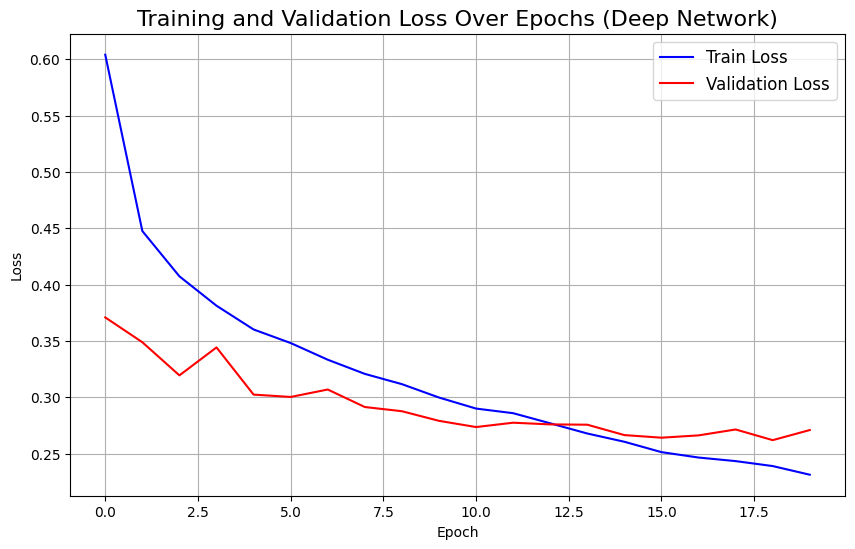

In [10]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(deep_train_loss, label='Train Loss', color='blue')
plt.plot(deep_val_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Deep Network)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

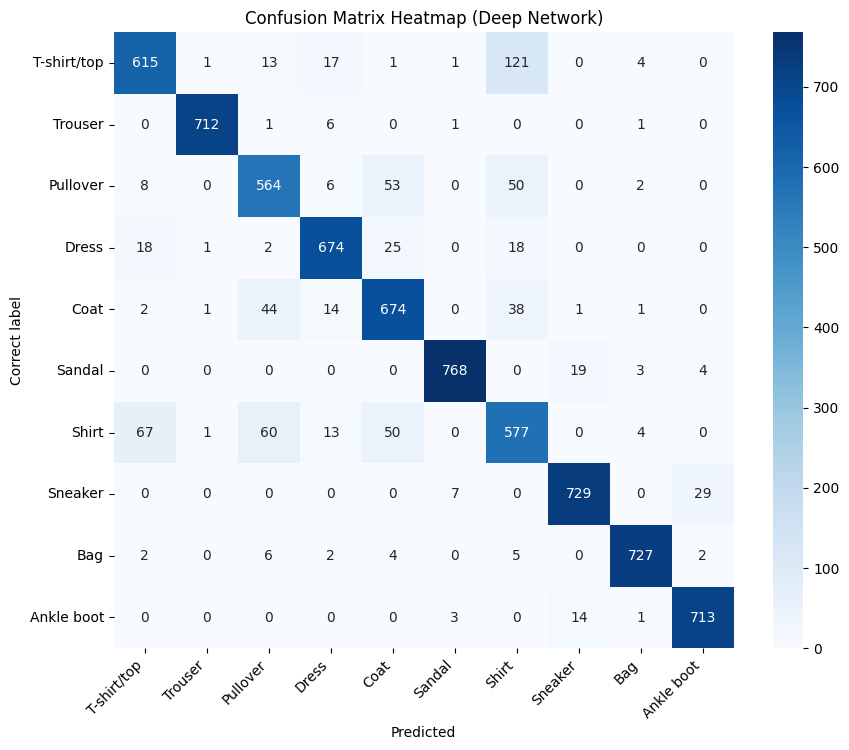

In [ ]:
# Compute confusion matrix for DNN model
conf_matrix_1 = confusion_matrix(deep_true_labels , deep_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', xticklabels=fashion_mnist_classes, yticklabels=fashion_mnist_classes)
plt.title("Confusion Matrix Heatmap (Deep Network)")
plt.xlabel('Predicted')
plt.ylabel('Correct label')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.show()

Wide Neural Network Model (WNN)

In [ ]:
# # 2-layer WNN with dropout for FashionMNIST classification
# class WNN(nn.Module):
#     def __init__(self):
#         super(WNN, self).__init__()
#         self.hidden1 = nn.Linear(28*28, 512)
#         self.output = nn.Linear(512, 10)
#         self.relu = nn.ReLU()
#         self.drop = nn.Dropout(0.5)
        
#     # Forward pass with ReLU and dropout
#     def forward(self, x):
#         x = x.view(-1, 28*28)
#         x = self.drop(self.relu(self.hidden1(x)))
#         x = self.output(x)
#         return x

In [16]:
# 2-layer WNN with dropout for FashionMNIST classification
class WNN(nn.Module):
    def __init__(self):
        super(WNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.output = nn.Linear(1024, 10)

        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        # Batch Normalization layer
        self.bn1 = nn.BatchNorm1d(1024)
  
    # Forward pass with ReLU, batch normalization, and dropout
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.drop(self.relu(self.bn1(self.fc1(x))))
        x = self.output(x)
        return x

In [13]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.4695, Validation Loss: 0.3882
Epoch [2/20], Loss: 0.3813, Validation Loss: 0.3376
Epoch [3/20], Loss: 0.3478, Validation Loss: 0.3204
Epoch [4/20], Loss: 0.3233, Validation Loss: 0.3453
Epoch [5/20], Loss: 0.3061, Validation Loss: 0.3049
Epoch [6/20], Loss: 0.2937, Validation Loss: 0.3079
Epoch [7/20], Loss: 0.2767, Validation Loss: 0.3173
Epoch [8/20], Loss: 0.2650, Validation Loss: 0.3012
Epoch [9/20], Loss: 0.2542, Validation Loss: 0.2866
Epoch [10/20], Loss: 0.2434, Validation Loss: 0.2958
Epoch [11/20], Loss: 0.2295, Validation Loss: 0.2854
Epoch [12/20], Loss: 0.2276, Validation Loss: 0.2974
Epoch [13/20], Loss: 0.2181, Validation Loss: 0.2884
Epoch [14/20], Loss: 0.2072, Validation Loss: 0.2939
Epoch [15/20], Loss: 0.2050, Validation Loss: 0.2991
Epoch [16/20], Loss: 0.1954, Validation Loss: 0.2899
Epoch [17/20], Loss: 0.1847, Validation Loss: 0.2900
Epoch [18/20], Loss: 0.1829, Validation Loss: 0.2861
Epoch [19/20], Loss: 0.1744, Validation Loss: 0.2969
Ep

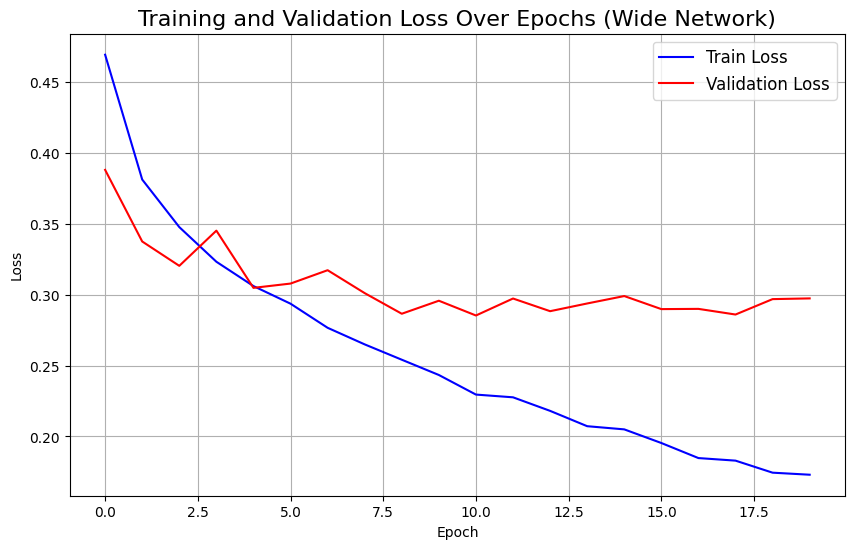

In [14]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(wide_train_loss, label='Train Loss', color='blue')
plt.plot(wide_val_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Wide Network)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

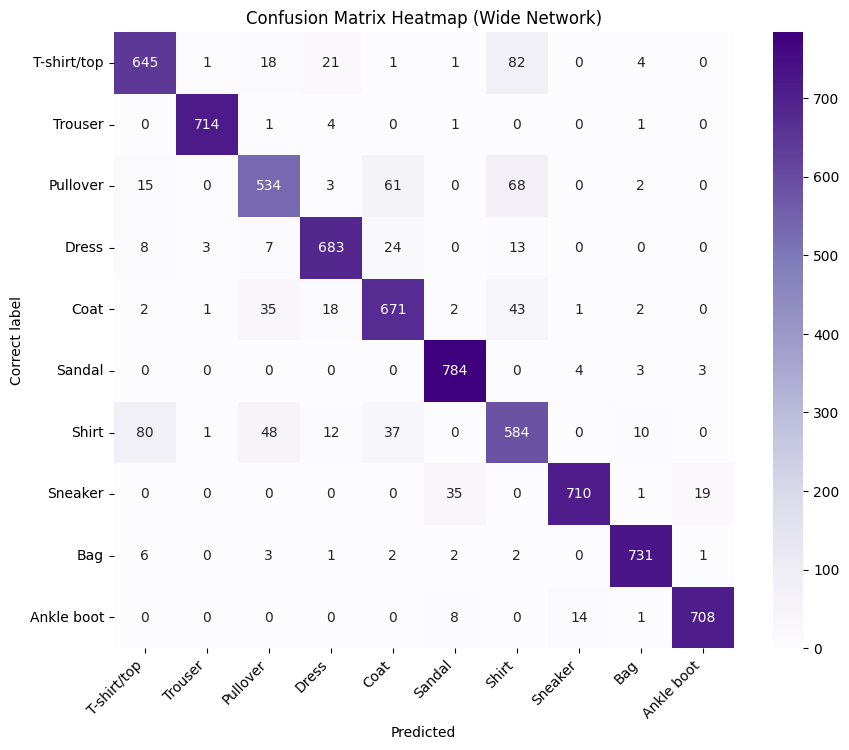

In [15]:
# Compute confusion matrix for WNN model
conf_matrix_2 = confusion_matrix(wide_true_labels, wide_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Purples', xticklabels=fashion_mnist_classes, yticklabels=fashion_mnist_classes)
plt.title("Confusion Matrix Heatmap (Wide Network)")
plt.xlabel('Predicted')
plt.ylabel('Correct label')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.show()

# Question 2

* *Part 1:*

He Initialization

In [16]:
class DNN(nn.Module): 
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.4)

        # He initialization 
        init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.output.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.drop1(self.relu(self.fc1(x)))
        x = self.drop1(self.relu(self.fc2(x)))
        x = self.drop2(self.relu(self.fc3(x)))
        x = self.drop2(self.relu(self.fc4(x)))
        x = self.output(x)
        return x

In [17]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.8082, Validation Loss: 0.4458
Epoch [2/20], Loss: 0.5433, Validation Loss: 0.4022
Epoch [3/20], Loss: 0.4902, Validation Loss: 0.3935
Epoch [4/20], Loss: 0.4680, Validation Loss: 0.3719
Epoch [5/20], Loss: 0.4477, Validation Loss: 0.3628
Epoch [6/20], Loss: 0.4339, Validation Loss: 0.3618
Epoch [7/20], Loss: 0.4162, Validation Loss: 0.3354
Epoch [8/20], Loss: 0.4055, Validation Loss: 0.3428
Epoch [9/20], Loss: 0.3960, Validation Loss: 0.3280
Epoch [10/20], Loss: 0.3892, Validation Loss: 0.3329
Epoch [11/20], Loss: 0.3791, Validation Loss: 0.3250
Epoch [12/20], Loss: 0.3753, Validation Loss: 0.3322
Epoch [13/20], Loss: 0.3686, Validation Loss: 0.3208
Epoch [14/20], Loss: 0.3620, Validation Loss: 0.3250
Epoch [15/20], Loss: 0.3592, Validation Loss: 0.3342
Epoch [16/20], Loss: 0.3593, Validation Loss: 0.3241
Epoch [17/20], Loss: 0.3516, Validation Loss: 0.3138
Epoch [18/20], Loss: 0.3490, Validation Loss: 0.3110
Epoch [19/20], Loss: 0.3475, Validation Loss: 0.3081
Ep

In [18]:
class WNN(nn.Module):
    def __init__(self):
        super(WNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024) 
        self.output = nn.Linear(1024, 10) 
        
        self.relu = nn.ReLU()  
        self.drop = nn.Dropout(0.3)  

        # He initialization 
        init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        init.kaiming_normal_(self.output.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.view(-1, 28*28) 
        x = self.drop(self.relu(self.fc1(x))) 
        x = self.output(x)  
        return x


In [19]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.5321, Validation Loss: 0.3959
Epoch [2/20], Loss: 0.4124, Validation Loss: 0.3608
Epoch [3/20], Loss: 0.3826, Validation Loss: 0.3348
Epoch [4/20], Loss: 0.3617, Validation Loss: 0.3227
Epoch [5/20], Loss: 0.3456, Validation Loss: 0.3232
Epoch [6/20], Loss: 0.3314, Validation Loss: 0.3156
Epoch [7/20], Loss: 0.3211, Validation Loss: 0.3159
Epoch [8/20], Loss: 0.3080, Validation Loss: 0.3055
Epoch [9/20], Loss: 0.2979, Validation Loss: 0.3048
Epoch [10/20], Loss: 0.2932, Validation Loss: 0.2970
Epoch [11/20], Loss: 0.2831, Validation Loss: 0.3083
Epoch [12/20], Loss: 0.2813, Validation Loss: 0.2972
Epoch [13/20], Loss: 0.2706, Validation Loss: 0.3029
Epoch [14/20], Loss: 0.2654, Validation Loss: 0.3021
Epoch [15/20], Loss: 0.2535, Validation Loss: 0.3069
Epoch [16/20], Loss: 0.2532, Validation Loss: 0.3066
Epoch [17/20], Loss: 0.2476, Validation Loss: 0.3102
Epoch [18/20], Loss: 0.2406, Validation Loss: 0.3107
Epoch [19/20], Loss: 0.2386, Validation Loss: 0.3180
Ep

Xavier Initialization

In [20]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.4)

        # Xavier Initialization
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.xavier_normal_(self.output.weight)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.drop1(self.relu(self.fc1(x)))
        x = self.drop1(self.relu(self.fc2(x)))
        x = self.drop2(self.relu(self.fc3(x)))
        x = self.drop2(self.relu(self.fc4(x)))
        x = self.output(x)
        return x

In [21]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.7297, Validation Loss: 0.4243
Epoch [2/20], Loss: 0.5230, Validation Loss: 0.4028
Epoch [3/20], Loss: 0.4735, Validation Loss: 0.3928
Epoch [4/20], Loss: 0.4545, Validation Loss: 0.3654
Epoch [5/20], Loss: 0.4323, Validation Loss: 0.3692
Epoch [6/20], Loss: 0.4188, Validation Loss: 0.3501
Epoch [7/20], Loss: 0.4040, Validation Loss: 0.3397
Epoch [8/20], Loss: 0.3946, Validation Loss: 0.3360
Epoch [9/20], Loss: 0.3851, Validation Loss: 0.3341
Epoch [10/20], Loss: 0.3734, Validation Loss: 0.3231
Epoch [11/20], Loss: 0.3693, Validation Loss: 0.3134
Epoch [12/20], Loss: 0.3630, Validation Loss: 0.3293
Epoch [13/20], Loss: 0.3617, Validation Loss: 0.3267
Epoch [14/20], Loss: 0.3542, Validation Loss: 0.3160
Epoch [15/20], Loss: 0.3525, Validation Loss: 0.3194
Epoch [16/20], Loss: 0.3454, Validation Loss: 0.3015
Epoch [17/20], Loss: 0.3430, Validation Loss: 0.3217
Epoch [18/20], Loss: 0.3371, Validation Loss: 0.3084
Epoch [19/20], Loss: 0.3334, Validation Loss: 0.3111
Ep

In [22]:
class WNN(nn.Module):
    def __init__(self):
        super(WNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024) 
        self.output = nn.Linear(1024, 10)  
        
        self.relu = nn.ReLU()  
        self.drop = nn.Dropout(0.3) 

        # Xavier initialization
        init.xavier_normal_(self.fc1.weight)  
        init.xavier_normal_(self.output.weight)  

    def forward(self, x):
        x = x.view(-1, 28*28) 
        x = self.drop(self.relu(self.fc1(x))) 
        x = self.output(x) 
        return x

In [23]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.5258, Validation Loss: 0.3848
Epoch [2/20], Loss: 0.4140, Validation Loss: 0.3746
Epoch [3/20], Loss: 0.3855, Validation Loss: 0.3471
Epoch [4/20], Loss: 0.3601, Validation Loss: 0.3339
Epoch [5/20], Loss: 0.3460, Validation Loss: 0.3287
Epoch [6/20], Loss: 0.3346, Validation Loss: 0.3103
Epoch [7/20], Loss: 0.3180, Validation Loss: 0.3155
Epoch [8/20], Loss: 0.3110, Validation Loss: 0.3242
Epoch [9/20], Loss: 0.3005, Validation Loss: 0.3062
Epoch [10/20], Loss: 0.2947, Validation Loss: 0.3250
Epoch [11/20], Loss: 0.2878, Validation Loss: 0.3090
Epoch [12/20], Loss: 0.2768, Validation Loss: 0.3103
Epoch [13/20], Loss: 0.2684, Validation Loss: 0.3052
Epoch [14/20], Loss: 0.2669, Validation Loss: 0.3269
Epoch [15/20], Loss: 0.2586, Validation Loss: 0.3174
Epoch [16/20], Loss: 0.2535, Validation Loss: 0.2955
Epoch [17/20], Loss: 0.2521, Validation Loss: 0.3105
Epoch [18/20], Loss: 0.2428, Validation Loss: 0.3083
Epoch [19/20], Loss: 0.2383, Validation Loss: 0.3290
Ep

Random initialization

In [10]:
class DNN(nn.Module): 
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.drop2 = nn.Dropout(0.4)

        # Random initialization
        init.normal_(self.fc1.weight, mean=0.0, std=0.01)
        init.normal_(self.fc2.weight, mean=0.0, std=0.01)
        init.normal_(self.fc3.weight, mean=0.0, std=0.01)
        init.normal_(self.fc4.weight, mean=0.0, std=0.01)
        init.normal_(self.output.weight, mean=0.0, std=0.01)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.drop1(self.relu(self.fc1(x)))
        x = self.drop1(self.relu(self.fc2(x)))
        x = self.drop2(self.relu(self.fc3(x)))
        x = self.drop2(self.relu(self.fc4(x)))
        x = self.output(x)
        return x

In [11]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.7838, Validation Loss: 0.5338
Epoch [2/20], Loss: 0.5395, Validation Loss: 0.4156
Epoch [3/20], Loss: 0.4713, Validation Loss: 0.3975
Epoch [4/20], Loss: 0.4387, Validation Loss: 0.3896
Epoch [5/20], Loss: 0.4188, Validation Loss: 0.3622
Epoch [6/20], Loss: 0.4059, Validation Loss: 0.3861
Epoch [7/20], Loss: 0.3888, Validation Loss: 0.3687
Epoch [8/20], Loss: 0.3807, Validation Loss: 0.3558
Epoch [9/20], Loss: 0.3672, Validation Loss: 0.3419
Epoch [10/20], Loss: 0.3650, Validation Loss: 0.3204
Epoch [11/20], Loss: 0.3557, Validation Loss: 0.3303
Epoch [12/20], Loss: 0.3509, Validation Loss: 0.3339
Epoch [13/20], Loss: 0.3440, Validation Loss: 0.3210
Epoch [14/20], Loss: 0.3388, Validation Loss: 0.3344
Epoch [15/20], Loss: 0.3330, Validation Loss: 0.3259
Epoch [16/20], Loss: 0.3315, Validation Loss: 0.3264
Epoch [17/20], Loss: 0.3232, Validation Loss: 0.3146
Epoch [18/20], Loss: 0.3217, Validation Loss: 0.3157
Epoch [19/20], Loss: 0.3209, Validation Loss: 0.3070
Ep

In [12]:
class WNN(nn.Module):
    def __init__(self):
        super(WNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)  
        self.output = nn.Linear(1024, 10) 
        
        self.relu = nn.ReLU()  
        self.drop = nn.Dropout(0.3) 

        # Random initialization 
        init.normal_(self.fc1.weight, mean=0.0, std=0.01)  
        init.normal_(self.output.weight, mean=0.0, std=0.01) 

    def forward(self, x):
        x = x.view(-1, 28*28)  
        x = self.drop(self.relu(self.fc1(x)))  
        x = self.output(x)  
        return x

In [13]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.5248, Validation Loss: 0.4137
Epoch [2/20], Loss: 0.4141, Validation Loss: 0.3731
Epoch [3/20], Loss: 0.3810, Validation Loss: 0.3711
Epoch [4/20], Loss: 0.3575, Validation Loss: 0.3459
Epoch [5/20], Loss: 0.3399, Validation Loss: 0.3357
Epoch [6/20], Loss: 0.3263, Validation Loss: 0.3169
Epoch [7/20], Loss: 0.3166, Validation Loss: 0.3421
Epoch [8/20], Loss: 0.3047, Validation Loss: 0.3183
Epoch [9/20], Loss: 0.2942, Validation Loss: 0.3112
Epoch [10/20], Loss: 0.2900, Validation Loss: 0.3320
Epoch [11/20], Loss: 0.2796, Validation Loss: 0.3177
Epoch [12/20], Loss: 0.2775, Validation Loss: 0.3137
Epoch [13/20], Loss: 0.2690, Validation Loss: 0.3061
Epoch [14/20], Loss: 0.2604, Validation Loss: 0.3091
Epoch [15/20], Loss: 0.2578, Validation Loss: 0.3243
Epoch [16/20], Loss: 0.2493, Validation Loss: 0.3180
Epoch [17/20], Loss: 0.2455, Validation Loss: 0.3154
Epoch [18/20], Loss: 0.2393, Validation Loss: 0.3072
Epoch [19/20], Loss: 0.2381, Validation Loss: 0.3264
Ep

# Question 3

* *Part 1:*

Learning Rate=0.01

In [17]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.01)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.6265, Validation Loss: 0.4392
Epoch [2/20], Loss: 0.4823, Validation Loss: 0.3653
Epoch [3/20], Loss: 0.4457, Validation Loss: 0.3653
Epoch [4/20], Loss: 0.4138, Validation Loss: 0.3326
Epoch [5/20], Loss: 0.3974, Validation Loss: 0.3184
Epoch [6/20], Loss: 0.3815, Validation Loss: 0.3213
Epoch [7/20], Loss: 0.3661, Validation Loss: 0.3122
Epoch [8/20], Loss: 0.3579, Validation Loss: 0.3105
Epoch [9/20], Loss: 0.3454, Validation Loss: 0.2952
Epoch [10/20], Loss: 0.3315, Validation Loss: 0.3084
Epoch [11/20], Loss: 0.3235, Validation Loss: 0.3110
Epoch [12/20], Loss: 0.3175, Validation Loss: 0.2834
Epoch [13/20], Loss: 0.3100, Validation Loss: 0.3085
Epoch [14/20], Loss: 0.3020, Validation Loss: 0.2865
Epoch [15/20], Loss: 0.2923, Validation Loss: 0.2836
Epoch [16/20], Loss: 0.2895, Validation Loss: 0.2863
Epoch [17/20], Loss: 0.2805, Validation Loss: 0.2933
Epoch [18/20], Loss: 0.2771, Validation Loss: 0.2736
Epoch [19/20], Loss: 0.2727, Validation Loss: 0.2741
Ep

In [18]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.01)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.5461, Validation Loss: 0.4017
Epoch [2/20], Loss: 0.4097, Validation Loss: 0.3905
Epoch [3/20], Loss: 0.3788, Validation Loss: 0.3307
Epoch [4/20], Loss: 0.3600, Validation Loss: 0.3405
Epoch [5/20], Loss: 0.3471, Validation Loss: 0.3683
Epoch [6/20], Loss: 0.3343, Validation Loss: 0.3216
Epoch [7/20], Loss: 0.3210, Validation Loss: 0.3205
Epoch [8/20], Loss: 0.3107, Validation Loss: 0.3067
Epoch [9/20], Loss: 0.3010, Validation Loss: 0.3321
Epoch [10/20], Loss: 0.2939, Validation Loss: 0.3209
Epoch [11/20], Loss: 0.2843, Validation Loss: 0.3161
Epoch [12/20], Loss: 0.2793, Validation Loss: 0.3050
Epoch [13/20], Loss: 0.2693, Validation Loss: 0.3065
Epoch [14/20], Loss: 0.2634, Validation Loss: 0.3023
Epoch [15/20], Loss: 0.2632, Validation Loss: 0.3145
Epoch [16/20], Loss: 0.2551, Validation Loss: 0.3152
Epoch [17/20], Loss: 0.2530, Validation Loss: 0.3011
Epoch [18/20], Loss: 0.2430, Validation Loss: 0.3074
Epoch [19/20], Loss: 0.2404, Validation Loss: 0.3127
Ep

Learning Rate=0.1

In [19]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.1)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.9094, Validation Loss: 0.5456
Epoch [2/20], Loss: 0.7870, Validation Loss: 0.4998
Epoch [3/20], Loss: 0.7417, Validation Loss: 0.5360
Epoch [4/20], Loss: 0.7310, Validation Loss: 0.5006
Epoch [5/20], Loss: 0.7067, Validation Loss: 0.4328
Epoch [6/20], Loss: 0.6903, Validation Loss: 0.4506
Epoch [7/20], Loss: 0.6804, Validation Loss: 0.4548
Epoch [8/20], Loss: 0.6536, Validation Loss: 0.4441
Epoch [9/20], Loss: 0.6384, Validation Loss: 0.4389
Epoch [10/20], Loss: 0.6337, Validation Loss: 0.4401
Epoch [11/20], Loss: 0.6260, Validation Loss: 0.4120
Epoch [12/20], Loss: 0.6200, Validation Loss: 0.4117
Epoch [13/20], Loss: 0.6046, Validation Loss: 0.4518
Epoch [14/20], Loss: 0.6103, Validation Loss: 0.3929
Epoch [15/20], Loss: 0.5958, Validation Loss: 0.3677
Epoch [16/20], Loss: 0.5914, Validation Loss: 0.3811
Epoch [17/20], Loss: 0.5916, Validation Loss: 0.3981
Epoch [18/20], Loss: 0.5890, Validation Loss: 0.3845
Epoch [19/20], Loss: 0.5831, Validation Loss: 0.3810
Ep

In [20]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.1)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.8232, Validation Loss: 0.4733
Epoch [2/20], Loss: 0.6421, Validation Loss: 0.4899
Epoch [3/20], Loss: 0.6434, Validation Loss: 0.4755
Epoch [4/20], Loss: 0.6218, Validation Loss: 0.4527
Epoch [5/20], Loss: 0.6199, Validation Loss: 0.5008
Epoch [6/20], Loss: 0.6131, Validation Loss: 0.4517
Epoch [7/20], Loss: 0.5994, Validation Loss: 0.4403
Epoch [8/20], Loss: 0.5999, Validation Loss: 0.4168
Epoch [9/20], Loss: 0.5845, Validation Loss: 0.4559
Epoch [10/20], Loss: 0.5900, Validation Loss: 0.4189
Epoch [11/20], Loss: 0.5842, Validation Loss: 0.4445
Epoch [12/20], Loss: 0.5768, Validation Loss: 0.4581
Epoch [13/20], Loss: 0.5755, Validation Loss: 0.4558
Epoch [14/20], Loss: 0.5834, Validation Loss: 0.4684
Epoch [15/20], Loss: 0.5743, Validation Loss: 0.4598
Epoch [16/20], Loss: 0.5993, Validation Loss: 0.4449
Epoch [17/20], Loss: 0.5960, Validation Loss: 0.4520
Epoch [18/20], Loss: 0.5907, Validation Loss: 0.4583
Epoch [19/20], Loss: 0.6173, Validation Loss: 0.4607
Ep

Learning Rate=1.0

In [21]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=1)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 2.6837, Validation Loss: 2.3391
Epoch [2/20], Loss: 2.4237, Validation Loss: 2.3764
Epoch [3/20], Loss: 2.3752, Validation Loss: 2.3612
Epoch [4/20], Loss: 2.3742, Validation Loss: 2.4558
Epoch [5/20], Loss: 2.3963, Validation Loss: 2.3611
Epoch [6/20], Loss: 2.3683, Validation Loss: 2.3382
Epoch [7/20], Loss: 2.3754, Validation Loss: 2.3730
Epoch [8/20], Loss: 2.3758, Validation Loss: 2.4564
Epoch [9/20], Loss: 2.3752, Validation Loss: 2.3321
Epoch [10/20], Loss: 2.3758, Validation Loss: 2.4023
Epoch [11/20], Loss: 2.3737, Validation Loss: 2.3845
Epoch [12/20], Loss: 2.3755, Validation Loss: 2.3768
Epoch [13/20], Loss: 2.3705, Validation Loss: 2.3759
Epoch [14/20], Loss: 2.3818, Validation Loss: 2.3690
Epoch [15/20], Loss: 2.3774, Validation Loss: 2.3387
Epoch [16/20], Loss: 2.3745, Validation Loss: 2.4382
Epoch [17/20], Loss: 2.3754, Validation Loss: 2.3964
Epoch [18/20], Loss: 2.3736, Validation Loss: 2.4025
Epoch [19/20], Loss: 2.3755, Validation Loss: 2.3529
Ep

In [22]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=1)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 5.0250, Validation Loss: 2.3764
Epoch [2/20], Loss: 2.4194, Validation Loss: 2.3856
Epoch [3/20], Loss: 2.4113, Validation Loss: 2.3348
Epoch [4/20], Loss: 2.3910, Validation Loss: 2.3747
Epoch [5/20], Loss: 2.3942, Validation Loss: 2.4247
Epoch [6/20], Loss: 2.4032, Validation Loss: 2.4011
Epoch [7/20], Loss: 2.4023, Validation Loss: 2.3618
Epoch [8/20], Loss: 2.3789, Validation Loss: 2.4311
Epoch [9/20], Loss: 2.3864, Validation Loss: 2.3683
Epoch [10/20], Loss: 2.3805, Validation Loss: 2.6004
Epoch [11/20], Loss: 2.3825, Validation Loss: 2.3704
Epoch [12/20], Loss: 2.3776, Validation Loss: 2.3655
Epoch [13/20], Loss: 2.3970, Validation Loss: 2.3495
Epoch [14/20], Loss: 2.3862, Validation Loss: 2.3790
Epoch [15/20], Loss: 2.4074, Validation Loss: 2.3417
Epoch [16/20], Loss: 2.3702, Validation Loss: 2.4140
Epoch [17/20], Loss: 2.3890, Validation Loss: 2.3395
Epoch [18/20], Loss: 2.3716, Validation Loss: 2.3431
Epoch [19/20], Loss: 2.3826, Validation Loss: 2.3830
Ep

* *Part 2:*

batch_size=32

In [23]:
trainloader = DataLoader(trainset, batch_size=32, shuffle=True) 
valloader = DataLoader(valset, batch_size=32, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [24]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.6257, Validation Loss: 0.4070
Epoch [2/20], Loss: 0.4761, Validation Loss: 0.3590
Epoch [3/20], Loss: 0.4379, Validation Loss: 0.3454
Epoch [4/20], Loss: 0.4056, Validation Loss: 0.3340
Epoch [5/20], Loss: 0.3872, Validation Loss: 0.3292
Epoch [6/20], Loss: 0.3694, Validation Loss: 0.3003
Epoch [7/20], Loss: 0.3502, Validation Loss: 0.3089
Epoch [8/20], Loss: 0.3442, Validation Loss: 0.3071
Epoch [9/20], Loss: 0.3298, Validation Loss: 0.2911
Epoch [10/20], Loss: 0.3206, Validation Loss: 0.2907
Epoch [11/20], Loss: 0.3131, Validation Loss: 0.2796
Epoch [12/20], Loss: 0.3027, Validation Loss: 0.2755
Epoch [13/20], Loss: 0.2930, Validation Loss: 0.2754
Epoch [14/20], Loss: 0.2859, Validation Loss: 0.2838
Epoch [15/20], Loss: 0.2809, Validation Loss: 0.2762
Epoch [16/20], Loss: 0.2736, Validation Loss: 0.2709
Epoch [17/20], Loss: 0.2674, Validation Loss: 0.2745
Epoch [18/20], Loss: 0.2675, Validation Loss: 0.2783
Epoch [19/20], Loss: 0.2568, Validation Loss: 0.2785
Ep

In [25]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.4991, Validation Loss: 0.4069
Epoch [2/20], Loss: 0.4066, Validation Loss: 0.3503
Epoch [3/20], Loss: 0.3718, Validation Loss: 0.3361
Epoch [4/20], Loss: 0.3435, Validation Loss: 0.3077
Epoch [5/20], Loss: 0.3263, Validation Loss: 0.3207
Epoch [6/20], Loss: 0.3083, Validation Loss: 0.3344
Epoch [7/20], Loss: 0.2957, Validation Loss: 0.2916
Epoch [8/20], Loss: 0.2817, Validation Loss: 0.2914
Epoch [9/20], Loss: 0.2699, Validation Loss: 0.2826
Epoch [10/20], Loss: 0.2605, Validation Loss: 0.2812
Epoch [11/20], Loss: 0.2482, Validation Loss: 0.2936
Epoch [12/20], Loss: 0.2418, Validation Loss: 0.2877
Epoch [13/20], Loss: 0.2347, Validation Loss: 0.2920
Epoch [14/20], Loss: 0.2291, Validation Loss: 0.2998
Epoch [15/20], Loss: 0.2166, Validation Loss: 0.2797
Epoch [16/20], Loss: 0.2125, Validation Loss: 0.2762
Epoch [17/20], Loss: 0.2037, Validation Loss: 0.2983
Epoch [18/20], Loss: 0.1973, Validation Loss: 0.2874
Epoch [19/20], Loss: 0.1963, Validation Loss: 0.2927
Ep

batch_size=128

In [26]:
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)  
valloader = DataLoader(valset, batch_size=128, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

In [27]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.6074, Validation Loss: 0.3893
Epoch [2/20], Loss: 0.4341, Validation Loss: 0.3548
Epoch [3/20], Loss: 0.3901, Validation Loss: 0.3618
Epoch [4/20], Loss: 0.3665, Validation Loss: 0.3190
Epoch [5/20], Loss: 0.3514, Validation Loss: 0.3240
Epoch [6/20], Loss: 0.3352, Validation Loss: 0.3109
Epoch [7/20], Loss: 0.3213, Validation Loss: 0.3200
Epoch [8/20], Loss: 0.3079, Validation Loss: 0.3063
Epoch [9/20], Loss: 0.2961, Validation Loss: 0.2894
Epoch [10/20], Loss: 0.2895, Validation Loss: 0.3036
Epoch [11/20], Loss: 0.2795, Validation Loss: 0.2931
Epoch [12/20], Loss: 0.2768, Validation Loss: 0.2804
Epoch [13/20], Loss: 0.2639, Validation Loss: 0.2901
Epoch [14/20], Loss: 0.2584, Validation Loss: 0.2815
Epoch [15/20], Loss: 0.2505, Validation Loss: 0.2867
Epoch [16/20], Loss: 0.2420, Validation Loss: 0.2819
Epoch [17/20], Loss: 0.2386, Validation Loss: 0.2695
Epoch [18/20], Loss: 0.2319, Validation Loss: 0.2809
Epoch [19/20], Loss: 0.2247, Validation Loss: 0.2821
Ep

In [28]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.4646, Validation Loss: 0.3928
Epoch [2/20], Loss: 0.3639, Validation Loss: 0.3748
Epoch [3/20], Loss: 0.3344, Validation Loss: 0.3286
Epoch [4/20], Loss: 0.3076, Validation Loss: 0.3215
Epoch [5/20], Loss: 0.2913, Validation Loss: 0.3425
Epoch [6/20], Loss: 0.2762, Validation Loss: 0.3358
Epoch [7/20], Loss: 0.2660, Validation Loss: 0.3008
Epoch [8/20], Loss: 0.2513, Validation Loss: 0.3032
Epoch [9/20], Loss: 0.2428, Validation Loss: 0.3053
Epoch [10/20], Loss: 0.2336, Validation Loss: 0.2974
Epoch [11/20], Loss: 0.2222, Validation Loss: 0.3079
Epoch [12/20], Loss: 0.2149, Validation Loss: 0.3145
Epoch [13/20], Loss: 0.2068, Validation Loss: 0.2807
Epoch [14/20], Loss: 0.2002, Validation Loss: 0.2997
Epoch [15/20], Loss: 0.1880, Validation Loss: 0.2992
Epoch [16/20], Loss: 0.1885, Validation Loss: 0.2994
Epoch [17/20], Loss: 0.1786, Validation Loss: 0.2978
Epoch [18/20], Loss: 0.1754, Validation Loss: 0.3163
Epoch [19/20], Loss: 0.1729, Validation Loss: 0.3148
Ep

batch_size=256

In [29]:
trainloader = DataLoader(trainset, batch_size=256, shuffle=True)  
valloader = DataLoader(valset, batch_size=256, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

In [30]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.Adam(deep_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.6469, Validation Loss: 0.4248
Epoch [2/20], Loss: 0.4319, Validation Loss: 0.3661
Epoch [3/20], Loss: 0.4007, Validation Loss: 0.3313
Epoch [4/20], Loss: 0.3654, Validation Loss: 0.3182
Epoch [5/20], Loss: 0.3460, Validation Loss: 0.3276
Epoch [6/20], Loss: 0.3290, Validation Loss: 0.3108
Epoch [7/20], Loss: 0.3189, Validation Loss: 0.3015
Epoch [8/20], Loss: 0.3061, Validation Loss: 0.3024
Epoch [9/20], Loss: 0.3003, Validation Loss: 0.3156
Epoch [10/20], Loss: 0.2928, Validation Loss: 0.2951
Epoch [11/20], Loss: 0.2806, Validation Loss: 0.2976
Epoch [12/20], Loss: 0.2697, Validation Loss: 0.2853
Epoch [13/20], Loss: 0.2619, Validation Loss: 0.3002
Epoch [14/20], Loss: 0.2612, Validation Loss: 0.2790
Epoch [15/20], Loss: 0.2535, Validation Loss: 0.2798
Epoch [16/20], Loss: 0.2419, Validation Loss: 0.2894
Epoch [17/20], Loss: 0.2416, Validation Loss: 0.2934
Epoch [18/20], Loss: 0.2589, Validation Loss: 0.2868
Epoch [19/20], Loss: 0.2436, Validation Loss: 0.2895
Ep

In [31]:
wide_net = WNN()
optimizer_wide = optim.Adam(wide_net.parameters(), lr=0.001)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.4696, Validation Loss: 0.4301
Epoch [2/20], Loss: 0.3624, Validation Loss: 0.3591
Epoch [3/20], Loss: 0.3292, Validation Loss: 0.3502
Epoch [4/20], Loss: 0.3097, Validation Loss: 0.3314
Epoch [5/20], Loss: 0.2833, Validation Loss: 0.3357
Epoch [6/20], Loss: 0.2724, Validation Loss: 0.3160
Epoch [7/20], Loss: 0.2601, Validation Loss: 0.3046
Epoch [8/20], Loss: 0.2422, Validation Loss: 0.3132
Epoch [9/20], Loss: 0.2368, Validation Loss: 0.3139
Epoch [10/20], Loss: 0.2277, Validation Loss: 0.3117
Epoch [11/20], Loss: 0.2292, Validation Loss: 0.3022
Epoch [12/20], Loss: 0.2157, Validation Loss: 0.2972
Epoch [13/20], Loss: 0.2039, Validation Loss: 0.2972
Epoch [14/20], Loss: 0.1898, Validation Loss: 0.3077
Epoch [15/20], Loss: 0.1904, Validation Loss: 0.2889
Epoch [16/20], Loss: 0.1799, Validation Loss: 0.2899
Epoch [17/20], Loss: 0.1749, Validation Loss: 0.3225
Epoch [18/20], Loss: 0.1722, Validation Loss: 0.3440
Epoch [19/20], Loss: 0.1702, Validation Loss: 0.2953
Ep

* *Part:3*

In [32]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True) 
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

SGD

In [33]:
deep_net = DNN()
criterion = nn.CrossEntropyLoss()
optimizer_deep = optim.SGD(deep_net.parameters(), lr=0.001, momentum=0.9)

# Lists to store loss values for each epoch
deep_train_loss, deep_val_loss = [], [] 

for epoch in range(20):
    # Training phase
    deep_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_deep.zero_grad()   # Reset gradients
        deep_outputs = deep_net(images)
        loss = criterion(deep_outputs, labels)
        loss.backward()
        optimizer_deep.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    deep_net.eval()
    val_loss = 0.0
    deep_pred_labels, deep_true_labels  = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            deep_outputs = deep_net(images)
            val_loss += criterion(deep_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(deep_outputs.data, 1)
            deep_pred_labels.extend(predicted.cpu().numpy())
            deep_true_labels .extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss/len(trainloader)
    avg_val_loss = val_loss/len(valloader)
    
    deep_train_loss.append(avg_train_loss)
    deep_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy 
accuracy = 100 * accuracy_score(deep_true_labels , deep_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.9900, Validation Loss: 0.4806
Epoch [2/20], Loss: 0.5824, Validation Loss: 0.4030
Epoch [3/20], Loss: 0.5110, Validation Loss: 0.3695
Epoch [4/20], Loss: 0.4721, Validation Loss: 0.3602
Epoch [5/20], Loss: 0.4456, Validation Loss: 0.3442
Epoch [6/20], Loss: 0.4263, Validation Loss: 0.3335
Epoch [7/20], Loss: 0.4095, Validation Loss: 0.3283
Epoch [8/20], Loss: 0.3942, Validation Loss: 0.3221
Epoch [9/20], Loss: 0.3873, Validation Loss: 0.3118
Epoch [10/20], Loss: 0.3753, Validation Loss: 0.3175
Epoch [11/20], Loss: 0.3662, Validation Loss: 0.3086
Epoch [12/20], Loss: 0.3541, Validation Loss: 0.3046
Epoch [13/20], Loss: 0.3469, Validation Loss: 0.3058
Epoch [14/20], Loss: 0.3479, Validation Loss: 0.3005
Epoch [15/20], Loss: 0.3351, Validation Loss: 0.3018
Epoch [16/20], Loss: 0.3288, Validation Loss: 0.2990
Epoch [17/20], Loss: 0.3269, Validation Loss: 0.3004
Epoch [18/20], Loss: 0.3191, Validation Loss: 0.2934
Epoch [19/20], Loss: 0.3162, Validation Loss: 0.2930
Ep

In [35]:
wide_net = WNN()
optimizer_wide = optim.SGD(wide_net.parameters(), lr=0.001, momentum=0.9)

# Lists to store loss values for each epoch
wide_train_loss, wide_val_loss = [], []

for epoch in range(20):
    # Training phase
    wide_net.train()
    total_loss = 0.0
    for images, labels in trainloader:
        optimizer_wide.zero_grad()   # Zero the gradients from the previous step
        wide_outputs = wide_net(images)
        loss = criterion(wide_outputs, labels)
        loss.backward()
        optimizer_wide.step()   # Update weights
        total_loss += loss.item()
    
    # Validation phase
    wide_net.eval()
    val_loss = 0.0
    wide_pred_labels, wide_true_labels = [], []
    
    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in valloader:
            wide_outputs = wide_net(images)
            val_loss += criterion(wide_outputs, labels).item()
            
            # Get predicted and true labels for evaluation
            _, predicted = torch.max(wide_outputs.data, 1)
            wide_pred_labels.extend(predicted.cpu().numpy())
            wide_true_labels.extend(labels.cpu().numpy())
    
    # Compute average training and validation loss
    avg_train_loss = total_loss / len(trainloader)
    avg_val_loss = val_loss / len(valloader)
    
    wide_train_loss.append(avg_train_loss)
    wide_val_loss.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/20], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Compute final accuracy
accuracy = 100 * accuracy_score(wide_true_labels, wide_pred_labels)
print(f'\nTest Accuracy: {accuracy:.2f}%')

Epoch [1/20], Loss: 0.5884, Validation Loss: 0.4191
Epoch [2/20], Loss: 0.4272, Validation Loss: 0.3767
Epoch [3/20], Loss: 0.3902, Validation Loss: 0.3576
Epoch [4/20], Loss: 0.3645, Validation Loss: 0.3489
Epoch [5/20], Loss: 0.3475, Validation Loss: 0.3334
Epoch [6/20], Loss: 0.3317, Validation Loss: 0.3259
Epoch [7/20], Loss: 0.3185, Validation Loss: 0.3255
Epoch [8/20], Loss: 0.3073, Validation Loss: 0.3121
Epoch [9/20], Loss: 0.2974, Validation Loss: 0.3091
Epoch [10/20], Loss: 0.2885, Validation Loss: 0.3020
Epoch [11/20], Loss: 0.2792, Validation Loss: 0.3024
Epoch [12/20], Loss: 0.2722, Validation Loss: 0.2969
Epoch [13/20], Loss: 0.2632, Validation Loss: 0.2981
Epoch [14/20], Loss: 0.2571, Validation Loss: 0.2932
Epoch [15/20], Loss: 0.2487, Validation Loss: 0.2898
Epoch [16/20], Loss: 0.2430, Validation Loss: 0.2914
Epoch [17/20], Loss: 0.2364, Validation Loss: 0.2831
Epoch [18/20], Loss: 0.2312, Validation Loss: 0.2916
Epoch [19/20], Loss: 0.2258, Validation Loss: 0.2883
Ep